# Kapitel: Grafikfunktionen

### Funktion: plot_bar_chart

Die Funktion `plot_bar_chart` erstellt ein anpassbares Balkendiagramm zur Visualisierung von Daten, wie zum Beispiel der prozentualen Verspätungsstatistik für verschiedene Zugkategorien. Sie ermöglicht eine flexible Anpassung des Diagrammtitels, der Achsenbeschriftungen und der Balkenfarben. Die Funktion kann auch optional Einträge mit einem Wert von 0 aus dem Diagramm ausschließen.

#### Parameter:
- **data (pd.DataFrame)**: Ein DataFrame, das die darzustellenden Daten enthält. Die Daten sollten mindestens zwei Spalten für die x- und y-Werte des Diagramms umfassen.
- **x_column (str, optional)**: Der Name der Spalte im DataFrame, die die Kategorien für die x-Achse enthält. Falls kein Wert angegeben wird, wird standardmäßig `'X'` verwendet.
- **y_column (str, optional)**: Der Name der Spalte im DataFrame, die die Werte für die y-Achse enthält. Falls kein Wert angegeben wird, wird standardmäßig `'Y'` verwendet.
- **title (str)**: Der Titel des Diagramms, der oben angezeigt wird.
- **x_axis_label (str)**: Die Bezeichnung der x-Achse.
- **y_axis_label (str)**: Die Bezeichnung der y-Achse.
- **bar_color (str)**: Die Farbe der Balken, die angezeigt werden soll (z. B. `'skyblue'`).
- **exclude_zeros (bool)**: Ein boolescher Wert, der festlegt, ob Einträge mit einem y-Wert von 0 aus dem Diagramm ausgeschlossen werden sollen. Standardmäßig ist dieser Wert `False`.

#### Rückgabewert:
Die Funktion gibt keinen Rückgabewert zurück, sondern zeigt das Balkendiagramm an.

#### Funktionsweise:
1. Überprüft, ob Spaltennamen für die x- und y-Werte übergeben wurden, und verwendet andernfalls die Standardwerte `'X'` und `'Y'`.
2. Filtert die Daten bei Bedarf, um Einträge mit einem y-Wert von 0 auszuschließen (wenn `exclude_zeros=True`).
3. Erstellt ein Balkendiagramm mit den Kategorien auf der x-Achse und den entsprechenden Werten auf der y-Achse.
4. Zeigt die Werte oberhalb jedes Balkens an und positioniert sie in einem Abstand von 3 % des maximalen y-Wertes über den Balken, um die Ablesbarkeit zu verbessern.
5. Setzt die y-Achse 10 % höher als den maximalen y-Wert, damit alle Beschriftungen vollständig sichtbar sind.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bar_chart(data, x_column=None, y_column=None, title='', x_axis_label='', y_axis_label='', 
                   bar_color='skyblue', y_limit_factor=1.1, text_offset_factor=0.03, 
                   show_values=True, exclude_zeros=True):
    """
    Diese Funktion erstellt ein Balkendiagramm mit anpassbaren Parametern wie Titel, Achsenbezeichner, Farben und Y-Achsen-Limit.
    
    Parameters:
    - data: DataFrame oder Dictionary mit den Daten für das Diagramm.
    - x_column: Name der Spalte für die x-Achse (Kategorien). Standardwert: 'X', falls nicht angegeben.
    - y_column: Name der Spalte für die y-Achse (Werte). Standardwert: 'Y', falls nicht angegeben.
    - title: Titel des Diagramms.
    - x_axis_label: Bezeichnung der x-Achse.
    - y_axis_label: Bezeichnung der y-Achse.
    - bar_color: Farbe der Balken (Standard: 'skyblue').
    - y_limit_factor: Faktor für die Y-Achsen-Limit (Standard: 1.1, um 10% oberhalb des Maximalwerts zu setzen).
    - text_offset_factor: Faktor zur Berechnung des Abstands für die Textanzeige (Standard: 3% über dem Balken).
    - show_values: Boolean, ob die Werte über den Balken angezeigt werden sollen (Standard: True).
    - exclude_zeros: Boolean, ob 0-Werte im Diagramm ausgeschlossen werden sollen (Standard: True).
    """
    
    # Setze Standardwerte für x_column und y_column, wenn sie nicht angegeben wurden
    if x_column is None:
        x_column = 'X'
    if y_column is None:
        y_column = 'Y'
    
    # Überprüfen, ob die erforderlichen Spalten vorhanden sind
    if not all(col in data.columns for col in [x_column, y_column]):
        raise ValueError(f"Die Eingabedaten müssen die Spalten '{x_column}' und '{y_column}' enthalten.")
    
    # Falls exclude_zeros True ist, alle Zeilen mit 0 im y_column entfernen
    if exclude_zeros:
        data = data[data[y_column] > 0]
    
    # Maximalwert berechnen und mit y_limit_factor multiplizieren
    y_limit = max(data[y_column]) * y_limit_factor
    
    # Balkendiagramm erstellen
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=x_column, y=y_column, data=data, color=bar_color)
    
    # Titel und Achsenbeschriftungen
    plt.title(title)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    
    # Berechnung des Textversatzes basierend auf dem höchsten Wert
    max_value = max(data[y_column])
    text_offset = max_value * text_offset_factor  # 3% des maximalen Werts
    
    # Werte über den Balken anzeigen, wenn show_values True ist
    if show_values:
        for bar in ax.patches:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval + text_offset, f"{yval:.1f}", ha='center', va='bottom')

    # Y-Achse auf y_limit setzen
    plt.ylim(0, y_limit)
    
    plt.show()

# Kapitel: Berechne Anzeigewerte

### Funktion: calculate_average_min_delay

Die `calculate_average_min_delay`-Funktion berechnet die durchschnittliche Verspätung pro Zugart aus einer CSV-Datei, die Verspätungsdaten enthält.

#### Parameter:
- **file_path**: Der Pfad zur CSV-Datei, die die Daten zur Verspätung enthält. Die Datei sollte zwei Spalten haben: `'Zugart'` und `'Verspätung in Minuten'`.
- **include_zero_delay** *(optional)*: Ein boolescher Parameter, der festlegt, ob Zugarten, deren durchschnittliche Verspätung Null Minuten beträgt, in die Berechnung einbezogen werden sollen. Wenn `True`, werden auch Einträge mit `0` Minuten Verspätung berücksichtigt. Standardwert ist `True`.

#### Rückgabewert:
Die Funktion gibt ein DataFrame mit zwei Spalten zurück:
- **Zugart**: Die Art des Zuges (z.B. ICE, RE).
- **Durchschnittliche Verspätung (Minuten)**: Die durchschnittliche Verspätung der jeweiligen Zugart in Minuten.

#### Funktionsweise:
1. Prüft, ob die Datei existiert. Falls nicht, wird ein `FileNotFoundError` ausgelöst.
2. Liest die CSV-Datei ohne Header ein und benennt die Spalten in `'Zugart'` und `'Verspätung in Minuten'`.
3. Berechnet die durchschnittliche Verspätung pro Zugart für Einträge mit mehr als 0 Minuten Verspätung.
4. Ergänzt die Anzahl der Vorkommen jeder Zugart und füllt fehlende Durchschnittswerte mit `0`.
5. Falls `include_zero_delay` auf `False` gesetzt ist, werden Zugarten mit einer durchschnittlichen Verspätung von `0` aus dem Ergebnis entfernt.


In [2]:
import pandas as pd
import os

def calculate_average_min_delay(file_path):
    # Überprüfen, ob der Dateipfad gültig ist
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Die Datei wurde nicht gefunden: {file_path}")
    
    # CSV-Datei einlesen, ohne Header
    df = pd.read_csv(file_path, header=None, names=['Zugart', 'Verspätung in Minuten'])
    
    # Durchschnittliche Verspätung pro Zugart berechnen (nur für Verspätungen > 0)
    avg_delay = df[df['Verspätung in Minuten'] > 0].groupby('Zugart')['Verspätung in Minuten'].mean().reset_index()
    
    # Spaltennamen anpassen
    avg_delay.columns = ['Zugart', 'Durchschnittliche Verspätung (Minuten)']
    
    # Alle Zugarten im ursprünglichen DataFrame beibehalten
    all_delays = df.groupby('Zugart')['Verspätung in Minuten'].count().reset_index()
    all_delays.columns = ['Zugart', 'Anzahl']

    # Zusammenführen der Durchschnittswerte mit der Anzahl
    result = pd.merge(all_delays, avg_delay, on='Zugart', how='left')

    # Füllen der fehlenden Durchschnittswerte mit 0
    result['Durchschnittliche Verspätung (Minuten)'] = result['Durchschnittliche Verspätung (Minuten)'].fillna(0)

    return result[['Zugart', 'Durchschnittliche Verspätung (Minuten)']]

### Funktion: calculate_average_percentage_delay

Die `calculate_average_percentage_delay`-Funktion berechnet den prozentualen Anteil verspäteter Züge pro Zugart aus einer CSV-Datei, die Verspätungsdaten enthält.

#### Parameter:
- **file_path**: Der Pfad zur CSV-Datei, die die Daten zur Verspätung enthält. Die Datei sollte zwei Spalten haben: `'Zugart'` und `'Verspätung (Minuten)'`, wobei die erste Zeile keinen Header enthält.
  
#### Rückgabewert:
Die Funktion gibt ein DataFrame mit zwei Spalten zurück:
- **Zugart**: Die Art des Zuges (z.B. ICE, IC, RE, S-Bahn).
- **Verspätet (%)**: Der prozentuale Anteil der verspäteten Züge der jeweiligen Zugart, basierend auf den Einträgen mit mehr als 0 Minuten Verspätung.

#### Funktionsweise:
1. Prüft, ob die Datei existiert. Falls nicht, wird ein `FileNotFoundError` ausgelöst.
2. Liest die CSV-Datei ohne Header ein und benennt die Spalten in `'Zugart'` und `'Verspätung (Minuten)'`.
3. Berechnet die Anzahl der verspäteten Züge und die Gesamtanzahl der Züge pro Zugart.
4. Ermittelt den prozentualen Anteil verspäteter Züge für jede Zugart.
5. Gibt ein DataFrame mit den Zugarten und dem entsprechenden Verspätungsanteil zurück.


In [3]:
import pandas as pd

def calculate_average_percentage_delay(file_path):
    # CSV-Datei einlesen ohne Header
    df = pd.read_csv(file_path, header=None, names=['Zugart', 'Verspätung (Minuten)'])
    
    # Zähle die Gesamtzahl der Züge pro Zugart und die Anzahl der verspäteten Züge
    total_counts = df['Zugart'].value_counts()
    delayed_counts = df[df['Verspätung (Minuten)'] > 0]['Zugart'].value_counts()
    
    # Berechnung des prozentualen Anteils verspäteter Züge
    delay_percentage = (delayed_counts / total_counts * 100).fillna(0).reset_index()
    delay_percentage.columns = ['Zugart', 'Verspätet (%)']
    
    return delay_percentage

### Funktion: delay_statistics_by_train_type

Die Funktion `delay_statistics_by_train_type` berechnet die prozentuale Verspätungsstatistik für eine spezifische Zugart in verschiedenen Zeitkategorien.

#### Parameter:
- **file_path (str)**: Der Pfad zur CSV-Datei, die die Verspätungsdaten enthält. Die Datei sollte die Spalten `'Zugart'` und `'Verspätung in Minuten'` enthalten.
- **train_type (str)**: Das Kürzel der Zugart, für die die Verspätungsstatistik berechnet werden soll (z. B. `'ICE'`).

#### Rückgabewert:
Die Funktion gibt ein Dictionary mit den Verspätungskategorien und den jeweiligen prozentualen Anteilen zurück. Wenn die Zugart nicht vorhanden ist oder keine verspäteten Einträge existieren, wird eine entsprechende Meldung ausgegeben.

#### Funktionsweise:
1. Überprüft, ob die Datei existiert und liest die CSV-Daten ein.
2. Filtert die Daten, um nur die Einträge der gewählten Zugart zu behalten.
3. Prüft, ob es verspätete Züge dieser Zugart gibt:
4. Falls keine Einträge oder keine Verspätungen vorhanden sind, wird eine Meldung zurückgegeben.
5. Berechnet die prozentualen Anteile verspäteter Züge in den Kategorien < 10 min, < 30 min, < 60 min, < 120 min und > 120 min.
6. Gibt das Dictionary mit den Verspätungskategorien und den zugehörigen Prozentwerten zurück.

In [4]:
import pandas as pd

def delay_statistics_by_train_type(file_path, train_type):
    # CSV-Datei einlesen
    df = pd.read_csv(file_path, header=None, names=['Zugart', 'Verspätung (Minuten)'])
    
    # Filtere die Daten für die angegebene Zugart
    df_filtered = df[df['Zugart'] == train_type]
    
    # Überprüfen, ob die Zugart vorhanden ist
    if df_filtered.empty:
        print(f"Zugart '{train_type}' ist in den Daten nicht vorhanden.")
        return None

    # Filtere auf verspätete Züge (> 0 Minuten)
    df_delayed = df_filtered[df_filtered['Verspätung (Minuten)'] > 0]
    
    # Überprüfen, ob die Zugart überhaupt Verspätungen hat
    if df_delayed.empty:
        print(f"Zugart '{train_type}' weist keine verspäteten Züge auf.")
        return None

    # Gesamtanzahl der verspäteten Züge der angegebenen Zugart
    total_delays = len(df_delayed)
    
    # Berechnung des prozentualen Anteils in jeder Kategorie
    delay_stats = {
        '< 10 min': (df_delayed['Verspätung (Minuten)'] < 10).sum() / total_delays * 100,
        '< 30 min': ((df_delayed['Verspätung (Minuten)'] >= 10) & (df_delayed['Verspätung (Minuten)'] < 30)).sum() / total_delays * 100,
        '< 60 min': ((df_delayed['Verspätung (Minuten)'] >= 30) & (df_delayed['Verspätung (Minuten)'] < 60)).sum() / total_delays * 100,
        '< 120 min': ((df_delayed['Verspätung (Minuten)'] >= 60) & (df_delayed['Verspätung (Minuten)'] < 120)).sum() / total_delays * 100,
        '> 120 min': (df_delayed['Verspätung (Minuten)'] >= 120).sum() / total_delays * 100
    }
    
    return delay_stats

# Tests

In [5]:
import pandas as pd

def load_csv_as_data(file_path):
    """
    Lädt eine CSV-Datei und gibt sie als DataFrame zurück.
    Alle Zeilen mit einem negativen 'arrival_delay' erhalten den Wert 0.
    
    :param file_path: Der Pfad zur CSV-Datei, die geladen werden soll.
    :return: DataFrame mit den gefilterten und angepassten Daten.
    """
    try:
        # CSV-Datei einlesen, unter der Annahme, dass die Spalten durch Semikolon getrennt sind
        df = pd.read_csv(file_path, sep=";", header=0)
        
        # Setze alle 'arrival_delay' Werte kleiner als 0 auf 0
        df['arrival_delay'] = df['arrival_delay'].apply(lambda x: max(x, 0))
    
    except FileNotFoundError:
        raise ValueError(f"Die Datei unter dem Pfad {file_path} wurde nicht gefunden.")
    except pd.errors.EmptyDataError:
        raise ValueError("Die CSV-Datei ist leer.")
    except KeyError:
        raise ValueError("Die CSV-Datei enthält keine Spalte 'arrival_delay'.")
    except Exception as e:
        raise ValueError(f"Fehler beim Einlesen der Datei: {e}")
    
    return df

In [6]:
import pandas as pd

def filter_data(data, eva=None, mode="min", date=None, week_number=None, delay_threshold=None):
    """
    Filtert die Daten basierend auf den gegebenen Parametern.
    
    :param data: DataFrame mit den zugrunde liegenden Daten.
    :param eva: Die EVN-Nummer des Bahnhofs, nach dem gefiltert werden soll (Optional).
    :param mode: Modus für die Verspätungsberechnung, entweder 'min' oder '%'.
    :param date: Das Datum, nach dem gefiltert werden soll (Optional, im Format 'YYYY-MM-DD').
    :param week_number: Die Kalenderwoche, nach der gefiltert werden soll (Optional).
    :param delay_threshold: Verspätung, ab der Züge berücksichtigt werden sollen (Optional).
    :return: Gefilterte Daten, die an die jeweilige Berechnungsfunktion übergeben werden können.
    """
    
    # Überprüfen, ob die Daten vorhanden sind
    if data.empty:
        print("Es sind keine Daten vorhanden.")
        return None
    
    # Stelle sicher, dass die EVA-Spalte als String behandelt wird
    data['eva'] = data['eva'].astype(str)
    
    # Wenn eva = '00000000', berücksichtige alle
    if eva != '00000000' and eva is not None:
        if eva not in data['eva'].values:
            print(f"Es gibt keinen Bahnhof mit der EVA {eva}.")
            return None
        data = data[data['eva'] == eva]
    
    # Wenn ein Datum angegeben ist, nach Jahr, Monat und Tag filtern
    if date:
        data['date'] = pd.to_datetime(data['plannedArrival']).dt.date
        data = data[data['date'] == pd.to_datetime(date).date()]
    
    # Wenn eine Kalenderwoche angegeben ist, nach dieser filtern
    if week_number:
        if date:
            print("Tag und Kalenderwoche können nicht gleichzeitig ausgewählt werden.")
            return None
        data['week_number'] = pd.to_datetime(data['plannedArrival']).dt.isocalendar().week
        data = data[data['week_number'] == week_number]
    
    # Wenn Verspätungsfilter angegeben ist, nur Züge mit Verspätung größer als der Schwellenwert
    #if delay_threshold is not None:
    #    data = data[data['arrival_delay'] >= delay_threshold]
    if delay_threshold is None:
        delay_threshold = 0
    
    # Überprüfen, ob der Modus gültig ist
    if mode not in ['min', '%']:
        print("Der Modus muss entweder 'min' oder '%' sein.")
        return None
    
    # Wenn alle Filter erfolgreich angewendet wurden, rufe die passende Funktion auf
    if mode == '%':
        return calculate_percentage_delay(data, delay_threshold)
    elif mode == 'min':
        return calculate_average_delay(data)

    return data

In [7]:
def calculate_average_delay(data):
    """
    Berechnet die durchschnittliche Verspätung in Minuten.
    
    :param data: Gefilterte Daten, auf die die Berechnung angewendet werden soll.
    :return: Durchschnittliche Verspätung in Minuten, die die Verspätung von Zügen mit mehr als 0 Minuten berücksichtigt.
    """
    
    if data.empty:
        print("Keine Daten für die Berechnung der Verspätung vorhanden.")
        return None
    
    # Nur Züge mit einer positiven Verspätung berücksichtigen
    delayed_data = data[data['arrival_delay'] > 0]
    
    if delayed_data.empty:
        print("Keine Züge mit Verspätung gefunden.")
        return None
    
    # Berechne die durchschnittliche Verspätung
    average_delay = delayed_data['arrival_delay'].mean()
    
    return average_delay


In [8]:
def calculate_percentage_delay(data, delay_threshold):
    """
    Berechnet den Prozentsatz der verspäteten Züge je Zugart.
    
    :param data: DataFrame mit den zugrunde liegenden Daten.
    :return: DataFrame mit der Zugkategorie und dem Prozentsatz der verspäteten Züge.
    """
    # Züge filtern, die mehr als 0 Minuten Verspätung haben
    delayed_trains = data[data['arrival_delay'] > delay_threshold]
    
    # Züge nach Zugart gruppieren
    total_trains_by_category = data.groupby('trainCategory').size()
    delayed_trains_by_category = delayed_trains.groupby('trainCategory').size()
    
    # Berechnung des Prozentsatzes der verspäteten Züge pro Zugart
    percentage_delay = (delayed_trains_by_category / total_trains_by_category) * 100
    
    # Ergebnis in DataFrame umwandeln
    result = percentage_delay.reset_index(name='Y')
    result['X'] = result['trainCategory']
    
    # Die Spalten umbenennen und das Format runden
    result = result[['X', 'Y']]
    result['Y'] = result['Y'].round(2)
    
    return result

In [ ]:
# Daten laden (z.B. aus CSV)
data = load_csv_as_data("sql/csv/ar-superquery.csv")

# Beispiel: Berechne Prozentsatz der verspäteten Züge für den Bahnhof mit EVA "8000105"
result = filter_data(data, eva="8000105", mode="%", delay_threshold=5.59)
if result is not None:
    print(result)


      X       Y
0   ECE   75.00
1   HLB   89.09
2    IC   86.49
3   ICE   70.22
4     N   93.10
5    NJ  100.00
6    RB   72.32
7    RE   78.61
8     S   75.00
9   TGV     NaN
10  VIA   82.19


# Kapitel: Ausführungsfunktionen

In [10]:
def print_avarage_delay_min(file_path, title='', x_axis_label='', y_axis_label='', 
                            bar_color='skyblue', y_limit_factor=1.1, text_offset_factor=0.03, 
                            show_values=True, exclude_zeros=True):
    statistics = calculate_average_min_delay(file_path)
    
    # Spaltennamen umbenennen, um sie in plot_bar_chart zu verwenden
    statistics.columns = ['X', 'Y']
    
    plot_bar_chart(statistics, title=title, 
                   x_axis_label=x_axis_label, y_axis_label=y_axis_label, 
                   bar_color=bar_color, y_limit_factor=y_limit_factor, text_offset_factor=text_offset_factor, 
                   show_values=show_values, exclude_zeros=exclude_zeros)

In [11]:
def print_avarage_delay_percentage(file_path, title='', x_axis_label='', y_axis_label='', 
                            bar_color='skyblue', y_limit_factor=1.1, text_offset_factor=0.03, 
                            show_values=True, exclude_zeros=True):
    statistics = calculate_average_percentage_delay(file_path)

    # Spaltennamen umbenennen, um sie in plot_bar_chart zu verwenden
    statistics.columns = ['X', 'Y']

    plot_bar_chart(statistics, title=title, 
                   x_axis_label=x_axis_label, y_axis_label=y_axis_label, 
                   bar_color=bar_color, y_limit_factor=y_limit_factor, text_offset_factor=text_offset_factor, 
                   show_values=show_values, exclude_zeros=exclude_zeros)

In [12]:
def print_delay_categorie_percentage(file_path, train_type, title='', x_axis_label='', y_axis_label='', 
                            bar_color='skyblue', y_limit_factor=1.1, text_offset_factor=0.03, 
                            show_values=True, exclude_zeros=True):
    statistics = delay_statistics_by_train_type(file_path, train_type)

    if statistics:
        # Spaltennamen umbenennen, um sie in plot_bar_chart zu verwenden
        statistics = pd.DataFrame(list(statistics.items()), columns=['X', 'Y'])

        plot_bar_chart(statistics, title=title, 
                   x_axis_label=x_axis_label, y_axis_label=y_axis_label, 
                   bar_color=bar_color, y_limit_factor=y_limit_factor, text_offset_factor=text_offset_factor, 
                   show_values=show_values, exclude_zeros=exclude_zeros) 

# Kapitel: Visualisierung

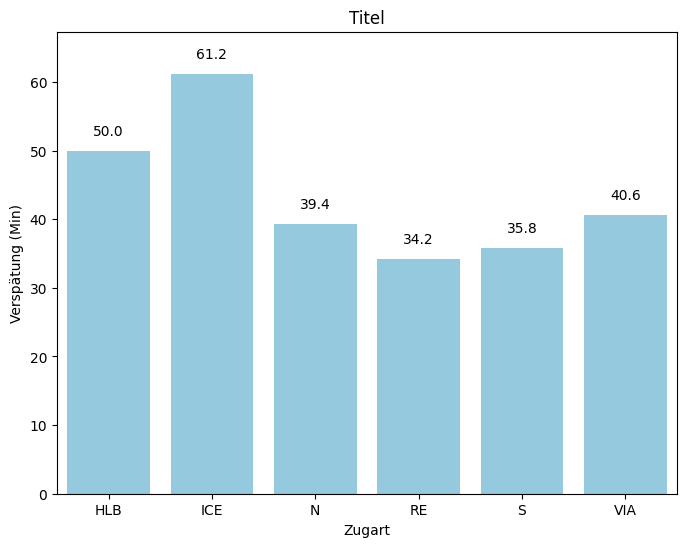

In [13]:
file_path = "out/Result_41.csv"

print_avarage_delay_min(file_path, title="Titel", x_axis_label="Zugart", y_axis_label="Verspätung (Min)")

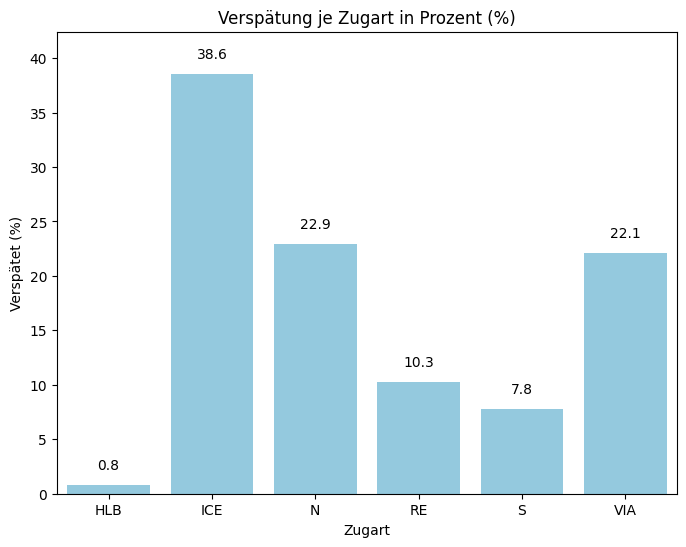

In [14]:
file_path = "out/Result_41.csv"

print_avarage_delay_percentage(file_path, title='Verspätung je Zugart in Prozent (%)', x_axis_label='Zugart', y_axis_label='Verspätet (%)')

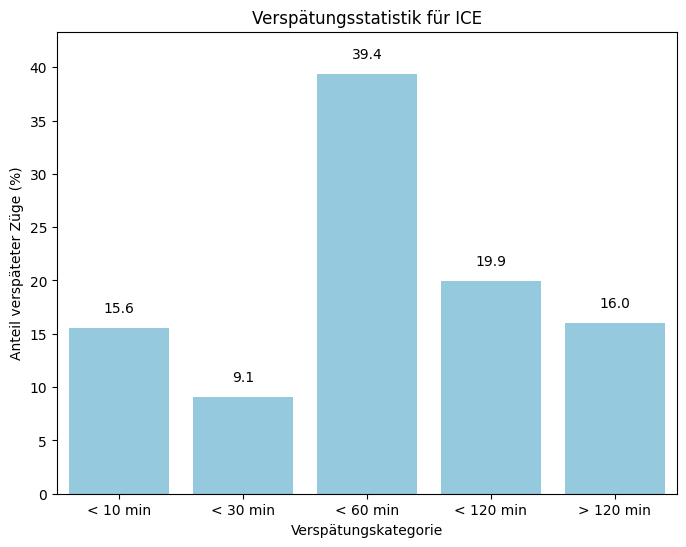

In [15]:
file_path = "out/Result_41.csv"
train_type_shortcut = "ICE"

title = train_type_shortcut
if train_type_shortcut == "S":
    title = "S-Bahn"

print_delay_categorie_percentage(file_path, train_type_shortcut, 
                                 title=f"Verspätungsstatistik für {title}", 
                                 x_axis_label="Verspätungskategorie", 
                                 y_axis_label="Anteil verspäteter Züge (%)",
                                 exclude_zeros=False)